In [ ]:
!pip install hickle

In [67]:
import os
import pandas as pd
import shutil
import tempfile
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import numpy as np
import PIL
from PIL import Image, ImageChops, ImageDraw
import torch
from torch import nn
import torchvision.models
import cv2
from skimage.morphology import skeletonize

from pathlib import Path

import tensorflow as tf
from tensorflow import keras
import matplotlib.patches as patches

from tqdm import tqdm

In [2]:
!nvidia-smi

Fri Jun 10 16:15:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   58C    P0    60W / 149W |  10904MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

### Load Model

In [ ]:
fundus_classifier = keras.models.load_model('models/ROP-256x25680-20-split-resnet18-Float16_2-race_detection_rop_seg_data_fundus_rop_seg-0.001_20220419-040552_epoch:021.hdf5')

In [ ]:
fundus_classifier

In [3]:
segmentation_classifier = keras.models.load_model('models/MIMIC-256x25680-20-split-resnet-Float16_2-race_detection_rop_seg_data_rop_seg-0.001_20220321-054140_epoch:011.hdf5')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [ ]:
fundus_classifier.summary()

In [4]:
segmentation_classifier.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           input_3[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_68 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_68[0][0]          
______________________________________________________________________________________

## Test Classifier

In [ ]:
img_class = Image.open("/users/riya/race/dataset/segmentations/7445.bmp")

In [ ]:
arr_class = np.array(img_class)

In [ ]:
resized_class = cv2.resize(arr_class, (256, 256))

### Method 1: 2D image repeated thrice - to make three channels

In [ ]:
channels_class = np.repeat(resized_class[:, :, np.newaxis], 3, axis=2).reshape((1,256,256,3))

In [ ]:
arr_class.shape, resized_class.shape, channels_class.shape

In [ ]:
# unnecessary 
tensor = tf.convert_to_tensor(channels_class)

In [ ]:
plt.imshow(np.reshape(channels_class, (256, 256, 3)), interpolation='nearest')
plt.show()

In [ ]:
# right pred 
segmentation_classifier(channels_class)

In [ ]:
tensor_class = segmentation_classifier(channels_class)

In [ ]:
tensor_class

In [ ]:
tensor_class.numpy()[0,1]

## Test Skeletonization

In [41]:
img_skel = np.array(Image.open("/users/riya/race/dataset/segmentations/7445.bmp"))
img_skel = cv2.resize(img_skel, (256, 256))

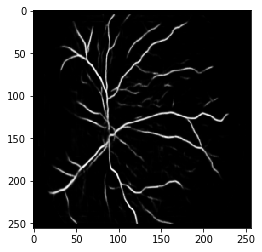

In [79]:
plt.imshow(img_skel, cmap = 'gray', interpolation='nearest')
plt.show()

In [42]:
img_skel.dtype

dtype('uint8')

In [76]:
img_binarize = np.copy(img_skel)
img_binarize[img_binarize > 0] = 255

In [80]:
img_thin = skeletonize(img_binarize, method='lee')

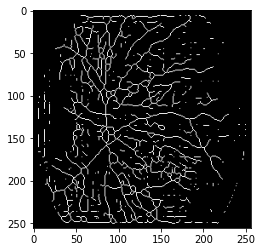

In [81]:
plt.imshow(img_thin, cmap='gray')
plt.show()

## Test Shadowing

In [101]:
img_thresh = np.array(Image.open("/users/riya/race/dataset/segmentations/7445.bmp"))

In [102]:
img_thresh.shape

(480, 640)

In [6]:
img_thresh = cv2.resize(img_thresh, (256, 256))

In [7]:
channels_thresh = np.repeat(img_thresh[:, :, np.newaxis], 3, axis=2).reshape((1,256,256,3))

In [8]:
channels_thresh.shape

(1, 256, 256, 3)

In [9]:
img_thresh_display = np.reshape(channels_thresh, (256, 256, 3))

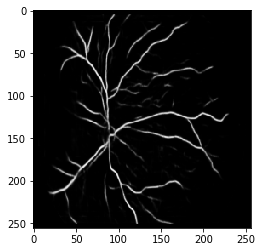

In [10]:
plt.imshow(img_thresh_display, interpolation='nearest')
plt.show()

In [11]:
# mask
mask = np.full((256, 256), 255, dtype=np.uint8)
cv2.circle(mask, (128, 128), 50, (0, 0, 0), -1)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

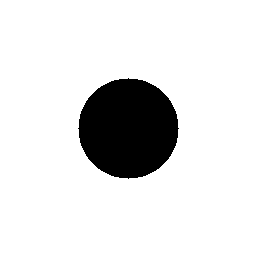

In [12]:
display(Image.fromarray(mask))

In [13]:
fg = cv2.bitwise_or(img_thresh, img_thresh, mask=mask)

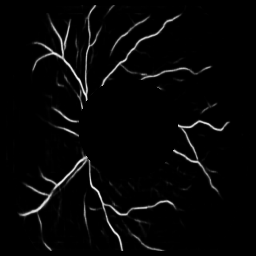

In [14]:
display(Image.fromarray(fg))

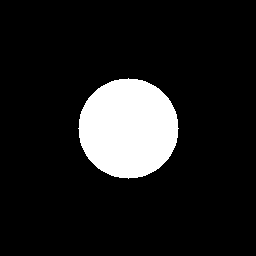

In [15]:
mask1 = cv2.bitwise_not(mask)
display(Image.fromarray(mask1))

In [16]:
bg = cv2.bitwise_or(img_thresh, img_thresh, mask=mask1)

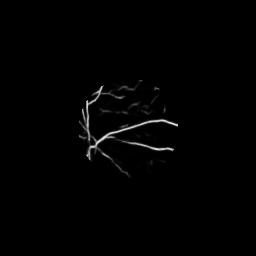

In [17]:
display(Image.fromarray(bg))

In [22]:
bg.shape

(256, 256)

Ok! We know what we want :)

# Preprocessing

### Paths

In [29]:
csv_path = "/users/riya/race/csv/image_race_data.csv"
data_path = "/users/riya/race/dataset/segmentations/"
dataset_experiment4 = "/users/riya/race/classifier_experiments/dataset/high_intensity_experiment4/"

### Load CSV

In [20]:
race_data = pd.read_csv(csv_path)

In [21]:
race_data

,subject_id,race,variable,value,image_id,fundus_location,segmentation_location
0,BEAU-0002,black,posterior,https://tctc.ohsu.edu/uploads/30121.bmp,30121,30121.png,30121.bmp
1,BEAU-0003,white,posterior,https://tctc.ohsu.edu/uploads/30672.bmp,30672,30672.png,30672.bmp
2,BEAU-0003,white,posterior,https://tctc.ohsu.edu/uploads/30676.bmp,30676,30676.png,30676.bmp
3,BEAU-0004,white,posterior,https://tctc.ohsu.edu/uploads/30630.bmp,30630,30630.png,30630.bmp
4,BEAU-0006,white,posterior,https://tctc.ohsu.edu/uploads/30696.bmp,30696,30696.png,30696.bmp
...,...,...,...,...,...,...,...
4541,RCOL-0042-EW,white,temporal,https://tctc.ohsu.edu/uploads/7572.png,7572,7572.png,7572.bmp
4542,RCOL-0042-EW,white,temporal,https://tctc.ohsu.edu/uploads/7576.png,7576,7576.png,7576.bmp
4543,RCOL-0042-EW,white,temporal,https://tctc.ohsu.edu/uploads/7579.png,7579,7579.png,7579.bmp
4544,RCOL-0055-GJ,black,temporal,https://tctc.ohsu.edu/uploads/7716.png,7716,7716.png,7716.bmp


## Skeletonization Function

In [82]:
def lee_skeletonization(img): # binarization first ofc
    
    # binarization
    img_binarize = np.copy(img)
    img_binarize[img_binarize > 0] = 255
    
    # skeletonize
    img_thin = skeletonize(img_binarize, method='lee')

    return img_thin

### Save Skeletonized Images

In [105]:
def save_skeletonized(data, load_path, save_path): # resizing original this time
    for i in tqdm(range(len(data))):
        img_id = data['image_id'][i]
            
        img = np.array(Image.open(load_path + str(img_id) + '.bmp'))
        # resized = cv2.resize(img, (256, 256))
            
        # skeletonize image          
        # skeletonized = lee_skeletonization(resized)
        img = Image.fromarray(img)


        # saving image
        img.save(save_path + 'original/' + str(img_id) + '.bmp')

In [106]:
save_skeletonized(race_data, data_path, dataset_experiment4)

100%|██████████| 4546/4546 [00:32<00:00, 140.83it/s]


## Shadow Images

In [98]:
def shadow_regions(data, load_path, save_path, radius_arr):
    
    for r in radius_arr:
        # developing mask that darkens center portion
        center_mask = np.full((256, 256), 255, dtype=np.uint8) 
        # radius i changes, center, color, fill is the same
        cv2.circle(center_mask, (128, 128), r, (0, 0, 0), -1)

        # developing mask that darkens background region
        back_mask = cv2.bitwise_not(center_mask)
  
        for i in tqdm(range(len(data))):
            img_id = data['image_id'][i]
            
            img = np.array(Image.open(load_path + str(img_id) + '.bmp'))
            resized = cv2.resize(img, (256, 256))
            
            # skeletonize image
            
            skeletonized = lee_skeletonization(resized)

            # applying center_mask, dark center
            center = cv2.bitwise_or(skeletonized, skeletonized, mask=center_mask)
            center = Image.fromarray(center)

            # applying background mask, dark background
            background = cv2.bitwise_or(skeletonized, skeletonized, mask=back_mask)
            background = Image.fromarray(background)

            # saving images
            center.save(save_path + 'shadow_center' + str(r) + '/' + str(img_id) + '.bmp')
            background.save(save_path + 'shadow_back' + str(r) + '/' + str(img_id) + '.bmp')

In [99]:
# test before build skeletonizing feature

shadow_regions(race_data, data_path, dataset_experiment4, [45, 90])

100%|██████████| 4546/4546 [01:47<00:00, 42.10it/s]


In [85]:
# quick test :) 

img_test = np.array(Image.open(dataset_experiment4 + "shadow_back90/" + "30121.bmp"))

In [86]:
img_test.shape

(256, 256)